## Clustering

In [85]:
# Import all necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geoplot as gplt
import contextily as cx

# also import these "new" libraries 
# Note: you may have to download and add them to your environment (using e.g. 'conda install -c conda-forge folium')
# !important! Install this version of plotly=5.10.0 or else some maps and animations may not render correctly
import plotly.express as px
import folium
from folium import plugins
from folium.plugins import HeatMap
from branca.element import Figure
import haversine as hs

# import the necessary libraries for the machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from shapely.geometry import Polygon
from h3 import h3

from haversine import haversine, Unit

As data we the Clustering part incorporates POI. Therefore first downloading the file POI.geojson and hexagons.csv is required

In [55]:
# Load Data
taxi_df_clustering = pd.read_parquet('data/prepared/taxi_data_prepared.gzip')
ddf_weather = pd.read_parquet("data/prepared/weather_data_hourly_prepared.gzip")

In [56]:
taxi_df_clustering = taxi_df_clustering.sample(200000, random_state=0)
taxi_df_clustering.reset_index(drop=True, inplace=True)

In [57]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location
0,2016-08-08 09:30:00,2016-08-08 10:00:00,2051,12.5,17031980100,17031081500,39.25,POINT (-87.7509342894 41.785998518),POINT (-87.6262149064 41.8925077809)
1,2016-01-04 20:15:00,2016-01-04 20:15:00,360,0.0,17031839100,17031081500,6.00,POINT (-87.6327464887 41.8809944707),POINT (-87.6262149064 41.8925077809)
2,2016-04-30 16:30:00,2016-04-30 16:30:00,360,1.2,17031320400,17031081403,7.75,POINT (-87.6219716519 41.8774061234),POINT (-87.6188683546 41.8909220259)
3,2016-06-09 15:30:00,2016-06-09 16:45:00,4620,17.3,17031081700,17031980000,46.50,POINT (-87.6318639497 41.8920421365),POINT (-87.9030396611 41.9790708201)
4,2016-03-30 13:30:00,2016-03-30 13:30:00,600,2.0,17031839100,17031081600,9.00,POINT (-87.6327464887 41.8809944707),POINT (-87.6288741572 41.8920726347)
...,...,...,...,...,...,...,...,...,...
199995,2016-08-16 20:15:00,2016-08-16 20:30:00,540,1.1,17031320100,17031281900,7.00,POINT (-87.6209929134 41.8849871918),POINT (-87.642648998 41.8792550844)
199996,2016-11-23 16:30:00,2016-11-23 16:45:00,419,1.3,17031839100,17031833000,7.75,POINT (-87.6327464887 41.8809944707),POINT (-87.6572331997 41.8852813201)
199997,2016-10-28 10:00:00,2016-10-28 10:15:00,300,1.7,17031320600,17031330100,8.25,POINT (-87.6221729369 41.8706073724),POINT (-87.6173580061 41.859349715)
199998,2016-06-07 17:15:00,2016-06-07 17:15:00,0,0.0,17031839100,17031839100,6.25,POINT (-87.6327464887 41.8809944707),POINT (-87.6327464887 41.8809944707)


### Importing POI Data

In [58]:
#Load hexagons
ddf_h3 = pd.read_csv("hexagons.csv").drop(columns="Unnamed: 0")

In [59]:
taxi_df_clustering = taxi_df_clustering.merge(ddf_h3[['pickup_centroid_location','h3_6']], how="left", on="pickup_centroid_location")

In [60]:
def get_n_poi_for_resolution(resolution="h3_6"):
    # get polygons from hexagon id
    df_hex = gpd.read_file("hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within')
    
    return poi_by_hex.groupby(resolution).size().to_frame().reset_index().rename(columns={0:"n_poi"})

In [61]:
def get_n_poi_for_resolution_and_amenity(resolution="h3_6"):
    # get polygons from hexagon id
    df_hex = gpd.read_file("hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within').groupby([resolution, "amenity"]).size().to_frame().reset_index()
    
    # generate according dataframe with features
    poi_features = []
    for hexagon in poi_by_hex[resolution].unique():
        di = {resolution: hexagon}
        for amenity in poi_by_hex.amenity.unique():
            n = poi_by_hex[(poi_by_hex[resolution] == hexagon) & (poi_by_hex["amenity"] == amenity)][0].values
            di[amenity] = n[0] if n.size > 0 else 0
        poi_features.append(di)
    
    return pd.DataFrame(poi_features)

In [62]:
poi_by_hex = get_n_poi_for_resolution()

C:\Users\Paulo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [63]:
poi_amenity_by_hex = get_n_poi_for_resolution_and_amenity()

C:\Users\Paulo\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [64]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,h3_6
0,2016-08-08 09:30:00,2016-08-08 10:00:00,2051,12.5,17031980100,17031081500,39.25,POINT (-87.7509342894 41.785998518),POINT (-87.6262149064 41.8925077809),862664527ffffff
1,2016-01-04 20:15:00,2016-01-04 20:15:00,360,0.0,17031839100,17031081500,6.00,POINT (-87.6327464887 41.8809944707),POINT (-87.6262149064 41.8925077809),862664c1fffffff
2,2016-04-30 16:30:00,2016-04-30 16:30:00,360,1.2,17031320400,17031081403,7.75,POINT (-87.6219716519 41.8774061234),POINT (-87.6188683546 41.8909220259),862664c1fffffff
3,2016-06-09 15:30:00,2016-06-09 16:45:00,4620,17.3,17031081700,17031980000,46.50,POINT (-87.6318639497 41.8920421365),POINT (-87.9030396611 41.9790708201),862664c1fffffff
4,2016-03-30 13:30:00,2016-03-30 13:30:00,600,2.0,17031839100,17031081600,9.00,POINT (-87.6327464887 41.8809944707),POINT (-87.6288741572 41.8920726347),862664c1fffffff
...,...,...,...,...,...,...,...,...,...,...
199995,2016-08-16 20:15:00,2016-08-16 20:30:00,540,1.1,17031320100,17031281900,7.00,POINT (-87.6209929134 41.8849871918),POINT (-87.642648998 41.8792550844),862664c1fffffff
199996,2016-11-23 16:30:00,2016-11-23 16:45:00,419,1.3,17031839100,17031833000,7.75,POINT (-87.6327464887 41.8809944707),POINT (-87.6572331997 41.8852813201),862664c1fffffff
199997,2016-10-28 10:00:00,2016-10-28 10:15:00,300,1.7,17031320600,17031330100,8.25,POINT (-87.6221729369 41.8706073724),POINT (-87.6173580061 41.859349715),862664c1fffffff
199998,2016-06-07 17:15:00,2016-06-07 17:15:00,0,0.0,17031839100,17031839100,6.25,POINT (-87.6327464887 41.8809944707),POINT (-87.6327464887 41.8809944707),862664c1fffffff


In [65]:
taxi_df_clustering = taxi_df_clustering.merge(poi_by_hex[['h3_6','n_poi']], how="left", on="h3_6")
taxi_df_clustering = taxi_df_clustering.merge(poi_amenity_by_hex[['h3_6','bar','pub','car_rental','clinic', 'ferry_terminal']], how="left", on="h3_6")
taxi_df_clustering['bar/pub'] = taxi_df_clustering['bar']+taxi_df_clustering['pub']
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,h3_6,n_poi,bar,pub,car_rental,clinic,ferry_terminal,bar/pub
0,2016-08-08 09:30:00,2016-08-08 10:00:00,2051,12.5,17031980100,17031081500,39.25,POINT (-87.7509342894 41.785998518),POINT (-87.6262149064 41.8925077809),862664527ffffff,252,96,24,108,0,0,120
1,2016-01-04 20:15:00,2016-01-04 20:15:00,360,0.0,17031839100,17031081500,6.00,POINT (-87.6327464887 41.8809944707),POINT (-87.6262149064 41.8925077809),862664c1fffffff,6394,3427,391,46,138,828,3818
2,2016-04-30 16:30:00,2016-04-30 16:30:00,360,1.2,17031320400,17031081403,7.75,POINT (-87.6219716519 41.8774061234),POINT (-87.6188683546 41.8909220259),862664c1fffffff,6394,3427,391,46,138,828,3818
3,2016-06-09 15:30:00,2016-06-09 16:45:00,4620,17.3,17031081700,17031980000,46.50,POINT (-87.6318639497 41.8920421365),POINT (-87.9030396611 41.9790708201),862664c1fffffff,6394,3427,391,46,138,828,3818
4,2016-03-30 13:30:00,2016-03-30 13:30:00,600,2.0,17031839100,17031081600,9.00,POINT (-87.6327464887 41.8809944707),POINT (-87.6288741572 41.8920726347),862664c1fffffff,6394,3427,391,46,138,828,3818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2016-08-16 20:15:00,2016-08-16 20:30:00,540,1.1,17031320100,17031281900,7.00,POINT (-87.6209929134 41.8849871918),POINT (-87.642648998 41.8792550844),862664c1fffffff,6394,3427,391,46,138,828,3818
199996,2016-11-23 16:30:00,2016-11-23 16:45:00,419,1.3,17031839100,17031833000,7.75,POINT (-87.6327464887 41.8809944707),POINT (-87.6572331997 41.8852813201),862664c1fffffff,6394,3427,391,46,138,828,3818
199997,2016-10-28 10:00:00,2016-10-28 10:15:00,300,1.7,17031320600,17031330100,8.25,POINT (-87.6221729369 41.8706073724),POINT (-87.6173580061 41.859349715),862664c1fffffff,6394,3427,391,46,138,828,3818
199998,2016-06-07 17:15:00,2016-06-07 17:15:00,0,0.0,17031839100,17031839100,6.25,POINT (-87.6327464887 41.8809944707),POINT (-87.6327464887 41.8809944707),862664c1fffffff,6394,3427,391,46,138,828,3818


### General Data Prep
Before we can start with the clustering, we add addtional features to our clustering dataframe.

As City Center we will consider the central business district of the city which widely know as the Loop, the main section of Downtown Chicago (Wikipedia). This corresponds to the location of 41.881111 (Latitude), -87.629722 (Longtitude). We will investigate clustering trip types based on their start distance to the city center.

In [66]:
taxi_df_clustering['pickup_centroid_location'] = gpd.GeoSeries.from_wkt(taxi_df_clustering['pickup_centroid_location'])
taxi_df_clustering['dropoff_centroid_location'] = gpd.GeoSeries.from_wkt(taxi_df_clustering['dropoff_centroid_location'])

# Converting the taxi_df_clustering to a GeoDataFrame
# !Note: The crs is set to 4326 which is the WGS84 coordinate system and must be used to show the coordinates properly on a map

taxi_df_clustering = gpd.GeoDataFrame(taxi_df_clustering, geometry='pickup_centroid_location', crs=4326)

#taxi_geo_df_locations = taxi_geo_df_locations['pickup_centroid_location']

In [67]:
# Calculating the distance between start coordinates and the city center
for i in range(0, len(taxi_df_clustering)):
    start_coordinates = (taxi_df_clustering['pickup_centroid_location'][i].y, taxi_df_clustering['pickup_centroid_location'][i].x)
    end_coordinates = (taxi_df_clustering['dropoff_centroid_location'][i].y, taxi_df_clustering['dropoff_centroid_location'][i].x)
    city_center = (41.881111, -87.629722)

    # Units need to be set to "Unit.MILES"
    taxi_df_clustering.at[i, 'distance_to_city_center_pickup'] = haversine(start_coordinates, city_center, unit=Unit.MILES)
    taxi_df_clustering.at[i, 'distance_to_city_center_dropoff'] = haversine(end_coordinates, city_center, unit=Unit.MILES)

In [68]:
#Additional Data of weekday, hour and date
taxi_df_clustering.loc[:,"weekday"] = taxi_df_clustering["trip_start_timestamp"].dt.weekday
taxi_df_clustering.loc[:,"start_hour"] = taxi_df_clustering["trip_start_timestamp"].dt.hour
taxi_df_clustering.loc[:,"end_hour"] = taxi_df_clustering["trip_end_timestamp"].dt.hour
taxi_df_clustering.loc[:,"date"] = taxi_df_clustering["trip_start_timestamp"].dt.date
taxi_df_clustering.loc[:,"month"] = taxi_df_clustering["trip_start_timestamp"].dt.month
taxi_df_clustering.loc[:,"day_of_year"] = taxi_df_clustering["trip_start_timestamp"].dt.dayofyear

# add datetime columns to weather df
#ddf_weather["start_hour"] = ddf_weather.time.dt.hour
#ddf_weather["date"] = ddf_weather.time.dt.date

# Merge with weather df
#taxi_df_clustering = taxi_df_clustering.merge(ddf_weather, on=["date", "start_hour"], how="inner")

In [69]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,h3_6,n_poi,bar,pub,car_rental,clinic,ferry_terminal,bar/pub,distance_to_city_center_pickup,distance_to_city_center_dropoff,weekday,start_hour,end_hour,date,month,day_of_year
0,2016-08-08 09:30:00,2016-08-08 10:00:00,2051,12.5,17031980100,17031081500,39.25,POINT (-87.75093 41.78600),POINT (-87.62621 41.89251),862664527ffffff,252,96,24,108,0,0,120,9.062283,0.807842,0,9,10,2016-08-08,8,221
1,2016-01-04 20:15:00,2016-01-04 20:15:00,360,0.0,17031839100,17031081500,6.00,POINT (-87.63275 41.88099),POINT (-87.62621 41.89251),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,0.807842,0,20,20,2016-01-04,1,4
2,2016-04-30 16:30:00,2016-04-30 16:30:00,360,1.2,17031320400,17031081403,7.75,POINT (-87.62197 41.87741),POINT (-87.61887 41.89092),862664c1fffffff,6394,3427,391,46,138,828,3818,0.473808,0.878185,5,16,16,2016-04-30,4,121
3,2016-06-09 15:30:00,2016-06-09 16:45:00,4620,17.3,17031081700,17031980000,46.50,POINT (-87.63186 41.89204),POINT (-87.90304 41.97907),862664c1fffffff,6394,3427,391,46,138,828,3818,0.763264,15.594652,3,15,16,2016-06-09,6,161
4,2016-03-30 13:30:00,2016-03-30 13:30:00,600,2.0,17031839100,17031081600,9.00,POINT (-87.63275 41.88099),POINT (-87.62887 41.89207),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,0.758631,2,13,13,2016-03-30,3,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2016-08-16 20:15:00,2016-08-16 20:30:00,540,1.1,17031320100,17031281900,7.00,POINT (-87.62099 41.88499),POINT (-87.64265 41.87926),862664c1fffffff,6394,3427,391,46,138,828,3818,0.522834,0.677254,1,20,20,2016-08-16,8,229
199996,2016-11-23 16:30:00,2016-11-23 16:45:00,419,1.3,17031839100,17031833000,7.75,POINT (-87.63275 41.88099),POINT (-87.65723 41.88528),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,1.444227,2,16,16,2016-11-23,11,328
199997,2016-10-28 10:00:00,2016-10-28 10:15:00,300,1.7,17031320600,17031330100,8.25,POINT (-87.62217 41.87061),POINT (-87.61736 41.85935),862664c1fffffff,6394,3427,391,46,138,828,3818,0.823116,1.632596,4,10,10,2016-10-28,10,302
199998,2016-06-07 17:15:00,2016-06-07 17:15:00,0,0.0,17031839100,17031839100,6.25,POINT (-87.63275 41.88099),POINT (-87.63275 41.88099),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,0.155795,1,17,17,2016-06-07,6,159


In [70]:
taxi_df_clustering.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   trip_start_timestamp             200000 non-null  datetime64[ns]
 1   trip_end_timestamp               200000 non-null  datetime64[ns]
 2   trip_seconds                     200000 non-null  uint32        
 3   trip_miles                       200000 non-null  float64       
 4   pickup_census_tract              200000 non-null  int64         
 5   dropoff_census_tract             200000 non-null  int64         
 6   trip_total                       200000 non-null  float64       
 7   pickup_centroid_location         200000 non-null  geometry      
 8   dropoff_centroid_location        200000 non-null  geometry      
 9   h3_6                             200000 non-null  object        
 10  n_poi                            200

### Functions to use for Clustering
Next we create a number of functions to help with frequent Clustering Steps:

In [71]:
# This function is used to standardize features
def scalingData(dataframe):
    newDataframe = dataframe.copy()
    scaler = StandardScaler()
    newDataframe[newDataframe.columns] = pd.DataFrame(scaler.fit_transform(newDataframe[newDataframe.columns]))
    return newDataframe

In [72]:
# This function calculates the Loss per cluster amount and plots the result of it in the range of 0-10 on the x-axis
def calcAndPlotLossKM(clusterAmount, dataframe):
    k_max = clusterAmount

    clusters = []
    losses = []

    for k in range(k_max):
        model = KMeans(n_clusters=k+1, n_init=10)
        model.fit(dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)

    fig = plt.subplots(figsize=(12,7))
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,10])
    plt.grid(True)
    plt.show()

In [73]:
# This function calculates for a defined amount of clusters KMeans on the given dataframe
def calcKMeans(numClusters, dataframe):
    result = KMeans(n_clusters=numClusters, n_init=10)
    result.fit(dataframe)

    dataframe['ClusterKM'] = result.predict(dataframe)

In [74]:
# This function calculates for a defined amount of clusters GMM on the given dataframe
def calcGMM(numClusters, dataframe):
    gmm = GaussianMixture(n_components=numClusters).fit(dataframe)
    dataframe['ClusterGMM'] = gmm.predict(dataframe)

In [75]:
# This function describes every KMeans or GMM cluster with the describe() function for the original dataframe
def describeData(originalDataframe, scaledDataframe, numClusters, method):   
    if(method == 'KMeans'):
        for i in range(0, numClusters):
            display(originalDataframe[scaledDataframe['ClusterKM'] == i].describe())
    elif(method == 'GMM'):
        for i in range(0, numClusters):    
            display(originalDataframe[scaledDataframe['ClusterGMM'] == i].describe())
    else:
        print('Error: The wrong method has been chosen. Either use "KMeans" or "GMM"!')

In [76]:
# This function removes outliers for a set of columns where values is n times larger than std
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        df = df.reset_index(drop=True)
        
    return df

## Clustering

Initially we start clustering trip/customer types with a sample of the complete dataset to allow shorter run times and easier tweaking of parameters. Furthemore, we begin with a hard clustering approach using KMeans to estimate good parameters (number of clusters) for the following soft clustering approach. The features considered for clustering are x,y,z.

In [77]:
pd.set_option('display.max_columns', None)

taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,h3_6,n_poi,bar,pub,car_rental,clinic,ferry_terminal,bar/pub,distance_to_city_center_pickup,distance_to_city_center_dropoff,weekday,start_hour,end_hour,date,month,day_of_year
0,2016-08-08 09:30:00,2016-08-08 10:00:00,2051,12.5,17031980100,17031081500,39.25,POINT (-87.75093 41.78600),POINT (-87.62621 41.89251),862664527ffffff,252,96,24,108,0,0,120,9.062283,0.807842,0,9,10,2016-08-08,8,221
1,2016-01-04 20:15:00,2016-01-04 20:15:00,360,0.0,17031839100,17031081500,6.00,POINT (-87.63275 41.88099),POINT (-87.62621 41.89251),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,0.807842,0,20,20,2016-01-04,1,4
2,2016-04-30 16:30:00,2016-04-30 16:30:00,360,1.2,17031320400,17031081403,7.75,POINT (-87.62197 41.87741),POINT (-87.61887 41.89092),862664c1fffffff,6394,3427,391,46,138,828,3818,0.473808,0.878185,5,16,16,2016-04-30,4,121
3,2016-06-09 15:30:00,2016-06-09 16:45:00,4620,17.3,17031081700,17031980000,46.50,POINT (-87.63186 41.89204),POINT (-87.90304 41.97907),862664c1fffffff,6394,3427,391,46,138,828,3818,0.763264,15.594652,3,15,16,2016-06-09,6,161
4,2016-03-30 13:30:00,2016-03-30 13:30:00,600,2.0,17031839100,17031081600,9.00,POINT (-87.63275 41.88099),POINT (-87.62887 41.89207),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,0.758631,2,13,13,2016-03-30,3,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2016-08-16 20:15:00,2016-08-16 20:30:00,540,1.1,17031320100,17031281900,7.00,POINT (-87.62099 41.88499),POINT (-87.64265 41.87926),862664c1fffffff,6394,3427,391,46,138,828,3818,0.522834,0.677254,1,20,20,2016-08-16,8,229
199996,2016-11-23 16:30:00,2016-11-23 16:45:00,419,1.3,17031839100,17031833000,7.75,POINT (-87.63275 41.88099),POINT (-87.65723 41.88528),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,1.444227,2,16,16,2016-11-23,11,328
199997,2016-10-28 10:00:00,2016-10-28 10:15:00,300,1.7,17031320600,17031330100,8.25,POINT (-87.62217 41.87061),POINT (-87.61736 41.85935),862664c1fffffff,6394,3427,391,46,138,828,3818,0.823116,1.632596,4,10,10,2016-10-28,10,302
199998,2016-06-07 17:15:00,2016-06-07 17:15:00,0,0.0,17031839100,17031839100,6.25,POINT (-87.63275 41.88099),POINT (-87.63275 41.88099),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,0.155795,1,17,17,2016-06-07,6,159


In [80]:
for i in range(0, len(taxi_df_clustering)):
    hour = taxi_df_clustering.at[i, 'start_hour']
    if(hour >= 6 and hour < 10):
        taxi_df_clustering.at[i, 'morning_commute'] = 1
    else:
        taxi_df_clustering.at[i, 'morning_commute'] = 0

In [81]:
taxi_df_clustering

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,trip_total,pickup_centroid_location,dropoff_centroid_location,h3_6,n_poi,bar,pub,car_rental,clinic,ferry_terminal,bar/pub,distance_to_city_center_pickup,distance_to_city_center_dropoff,weekday,start_hour,end_hour,date,month,day_of_year,morning_commute
0,2016-08-08 09:30:00,2016-08-08 10:00:00,2051,12.5,17031980100,17031081500,39.25,POINT (-87.75093 41.78600),POINT (-87.62621 41.89251),862664527ffffff,252,96,24,108,0,0,120,9.062283,0.807842,0,9,10,2016-08-08,8,221,1.0
1,2016-01-04 20:15:00,2016-01-04 20:15:00,360,0.0,17031839100,17031081500,6.00,POINT (-87.63275 41.88099),POINT (-87.62621 41.89251),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,0.807842,0,20,20,2016-01-04,1,4,0.0
2,2016-04-30 16:30:00,2016-04-30 16:30:00,360,1.2,17031320400,17031081403,7.75,POINT (-87.62197 41.87741),POINT (-87.61887 41.89092),862664c1fffffff,6394,3427,391,46,138,828,3818,0.473808,0.878185,5,16,16,2016-04-30,4,121,0.0
3,2016-06-09 15:30:00,2016-06-09 16:45:00,4620,17.3,17031081700,17031980000,46.50,POINT (-87.63186 41.89204),POINT (-87.90304 41.97907),862664c1fffffff,6394,3427,391,46,138,828,3818,0.763264,15.594652,3,15,16,2016-06-09,6,161,0.0
4,2016-03-30 13:30:00,2016-03-30 13:30:00,600,2.0,17031839100,17031081600,9.00,POINT (-87.63275 41.88099),POINT (-87.62887 41.89207),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,0.758631,2,13,13,2016-03-30,3,90,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2016-08-16 20:15:00,2016-08-16 20:30:00,540,1.1,17031320100,17031281900,7.00,POINT (-87.62099 41.88499),POINT (-87.64265 41.87926),862664c1fffffff,6394,3427,391,46,138,828,3818,0.522834,0.677254,1,20,20,2016-08-16,8,229,0.0
199996,2016-11-23 16:30:00,2016-11-23 16:45:00,419,1.3,17031839100,17031833000,7.75,POINT (-87.63275 41.88099),POINT (-87.65723 41.88528),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,1.444227,2,16,16,2016-11-23,11,328,0.0
199997,2016-10-28 10:00:00,2016-10-28 10:15:00,300,1.7,17031320600,17031330100,8.25,POINT (-87.62217 41.87061),POINT (-87.61736 41.85935),862664c1fffffff,6394,3427,391,46,138,828,3818,0.823116,1.632596,4,10,10,2016-10-28,10,302,0.0
199998,2016-06-07 17:15:00,2016-06-07 17:15:00,0,0.0,17031839100,17031839100,6.25,POINT (-87.63275 41.88099),POINT (-87.63275 41.88099),862664c1fffffff,6394,3427,391,46,138,828,3818,0.155795,0.155795,1,17,17,2016-06-07,6,159,0.0


In [ ]:
#Remove outliers in dataset as impact on clustering is significant
taxi_df_clustering = remove_outliers(taxi_df_clustering,['trip_miles'],3)

Making Feature Selection without including inherently correlated features.
E.g trip miles and trip duration, trip miles with both pickup and dropoff location, day of the year/hour and temperature.

In [ ]:
#Feature Selection for Clustering
#taxi_df_customer_types_cluster = taxi_df_clustering[['weekday','hour','pickup_census_tract']]
#taxi_df_customer_types_cluster = taxi_df_clustering[['weekday','trip_miles','temperature_2m (°C)']]
#taxi_df_customer_types_cluster = taxi_df_clustering[['hour','trip_miles','temperature_2m (°C)']]
#taxi_df_customer_types_cluster_selection1 = taxi_df_clustering[['trip_miles','pickup_census_tract','dropoff_census_tract','distance_to_city_center','weekday','month','start_hour','end_hour','bar/pub','car_rental']]
#taxi_df_customer_types_cluster = taxi_df_clustering[['pickup_census_tract','dropoff_census_tract','distance_to_city_center','weekday','temperature_2m (°C)','precipitation (mm)']]
#taxi_df_customer_types_cluster_selection1 = taxi_df_clustering[['hour','bar/pub','distance_to_city_center','car_rental','trip_miles']]
#taxi_df_customer_types_cluster_selection1 = taxi_df_clustering[['trip_miles','hour','bar/pub','weekday','precipitation (mm)']]
taxi_gpdf_customer_types_cluster_selection1 = taxi_df_clustering.drop(columns =['trip_seconds','trip_start_timestamp','trip_end_timestamp','trip_total','h3_6', 'n_poi',
                                                                              'bar','pub','car_rental','clinic','bar/pub','ferry_terminal','date','day_of_year', 'pickup_census_tract', 'dropoff_census_tract'])
taxi_gpdf_customer_types_cluster_selection1.info()

In [ ]:
taxi_gpdf_customer_types_cluster_selection1['pickup_centroid_location_lat'] = taxi_gpdf_customer_types_cluster_selection1['pickup_centroid_location'].y
taxi_gpdf_customer_types_cluster_selection1['pickup_centroid_location_lon'] = taxi_gpdf_customer_types_cluster_selection1['pickup_centroid_location'].x

taxi_gpdf_customer_types_cluster_selection1['dropoff_centroid_location_lat'] = taxi_gpdf_customer_types_cluster_selection1['dropoff_centroid_location'].y
taxi_gpdf_customer_types_cluster_selection1['dropoff_centroid_location_lon'] = taxi_gpdf_customer_types_cluster_selection1['dropoff_centroid_location'].x

In [ ]:
taxi_df_customer_types_cluster_selection1 = pd.DataFrame(taxi_gpdf_customer_types_cluster_selection1)

In [ ]:
taxi_df_customer_types_cluster_selection1.drop(columns=['pickup_centroid_location','dropoff_centroid_location', 
                                                #'pickup_centroid_location_lat', 'pickup_centroid_location_lon',
                                                #'dropoff_centroid_location_lat', 'dropoff_centroid_location_lon',
                                                'end_hour', 'month'],inplace=True)

In [ ]:
#Scaling the Data
taxi_df_customer_types_cluster_selection1_scaled = scalingData(taxi_df_customer_types_cluster_selection1)
taxi_df_customer_types_cluster_selection1_scaled

In [ ]:
#Sampling original and scaled Data
#taxi_df_customer_types_cluster_selection1_sample = taxi_df_customer_types_cluster_selection1.sample(n=200000, random_state=1).reset_index(drop=True)
#taxi_df_customer_types_cluster_selection1_scaled_sample = taxi_df_customer_types_cluster_selection1_scaled.sample(n=200000, random_state=1).reset_index(drop=True)

## PCA

In [ ]:
pca = PCA()
pca.fit(taxi_df_customer_types_cluster_selection1_scaled)

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(range(1,10), pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

As we want to keep the majority of variance explained by the components we settle for 6 out of the 10 components which roughly preserve 80% of the variance.

In [ ]:
pca = PCA(n_components = 5)

In [ ]:
pca.fit(taxi_df_customer_types_cluster_selection1_scaled)

In [ ]:
pca.transform(taxi_df_customer_types_cluster_selection1_scaled)

In [ ]:
scores_pca = pca.transform(taxi_df_customer_types_cluster_selection1_scaled)

In [ ]:
taxi_df_customer_types_cluster_selection1_scaled = pd.DataFrame(scores_pca, columns=['Component 1','Component 2','Component 3','Component 4','Component 5'])

In [ ]:
taxi_df_customer_types_cluster_selection1_scaled

### Hard Clustering with KMeans (Sample)

In [ ]:
#Calculating the Loss with increasing number of Clusters
calcAndPlotLossKM(10, taxi_df_customer_types_cluster_selection1_scaled)

In [ ]:
# Calculating KMeans
calcKMeans(3, taxi_df_customer_types_cluster_selection1_scaled)

# Adding the clusters from KMeans into the original dataframe 
taxi_df_customer_types_cluster_selection1.loc[:, 'ClusterKM'] = taxi_df_customer_types_cluster_selection1_scaled['ClusterKM']
taxi_gpdf_customer_types_cluster_selection1.loc[:, 'ClusterKM'] = taxi_df_customer_types_cluster_selection1_scaled['ClusterKM']
taxi_df_customer_types_cluster_selection1_scaled

In [ ]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_customer_types_cluster_selection1_scaled['Component 1'], ys=taxi_df_customer_types_cluster_selection1_scaled['Component 2'], zs=taxi_df_customer_types_cluster_selection1_scaled['Component 3'], c=taxi_df_customer_types_cluster_selection1_scaled['ClusterKM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Clustering Results KMeans')
plt.xlabel('start_hour')
plt.ylabel('distance_to_city_center')
ax.set_zlabel('trip_miles')
ax.zaxis.labelpad = 0
plt.show()

In [ ]:
describeData(taxi_df_customer_types_cluster_selection1, taxi_df_customer_types_cluster_selection1_scaled, 3, 'KMeans')

Cluster Descriptions

In [ ]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf', 4:'red', 5:'black'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_customer_types_cluster_selection1['start_hour'], ys=taxi_df_customer_types_cluster_selection1['distance_to_city_center_pickup'], zs=taxi_df_customer_types_cluster_selection1['trip_miles'], c=taxi_df_customer_types_cluster_selection1_scaled['ClusterKM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Clustering Results KMeans')
plt.xlabel('start_hour')
plt.ylabel('distance_to_city_center')
ax.set_zlabel('trip_miles')
ax.zaxis.labelpad = 0
plt.show()

In [ ]:
# Scatter Mapbox to display the clusters in a map
fig = px.scatter_mapbox(taxi_gpdf_customer_types_cluster_selection1, 
                        lat="pickup_centroid_location_lat", lon="pickup_centroid_location_lon", 
                        animation_frame='ClusterKM', opacity=1, 
                        #animation_group='start_station_name', 
                        zoom=12, height=1000, width=900, 
                        title='Locational Clusters based on the start stations')
fig.update_geos(center=dict(lon=-75.14, lat=39.96))
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
            size=18
        ))
#display(fig)

In [ ]:
# Scatter Mapbox to display the clusters in a map
#fig = px.scatter_mapbox(taxi_gpdf_customer_types_cluster_selection1, 
#                        lat="dropoff_centroid_location_lat", lon="dropoff_centroid_location_lon", 
#                        animation_frame='ClusterKM', opacity=1, 
#                        #animation_group='start_station_name', 
#                        zoom=12, height=1000, width=900, 
#                        title='Locational Clusters based on the start stations')
#fig.update_geos(center=dict(lon=-75.14, lat=39.96))
#fig.update_layout(mapbox_style="carto-positron")
#fig.update_layout(
#    title={
#        'y':0.95,
#        'x':0.5,
#        'xanchor': 'center',
#        'yanchor': 'top'},
#    font=dict(
#            size=18
#        ))
#display(fig)

### Soft Clustering with Gaussian Mixture Model (Sample)

In [ ]:
taxi_df_customer_types_cluster_selection1_scaled.drop(columns='ClusterKM',inplace=True)
taxi_df_customer_types_cluster_selection1_scaled

In [ ]:
# GMM
calcGMM(3, taxi_df_customer_types_cluster_selection1_scaled)

# Adding the clusters from KMeans into the original dataframe 
taxi_df_customer_types_cluster_selection1.loc[:, 'ClusterGMM'] = taxi_df_customer_types_cluster_selection1_scaled['ClusterGMM']
taxi_gpdf_customer_types_cluster_selection1.loc[:, 'ClusterGMM'] = taxi_df_customer_types_cluster_selection1_scaled['ClusterGMM']
taxi_df_customer_types_cluster_selection1_scaled

In [ ]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_customer_types_cluster_selection1_scaled['Component 1'], ys=taxi_df_customer_types_cluster_selection1_scaled['Component 2'], zs=taxi_df_customer_types_cluster_selection1_scaled['Component 3'], c=taxi_df_customer_types_cluster_selection1_scaled['ClusterGMM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Clustering Results KMeans')
plt.xlabel('start_hour')
plt.ylabel('distance_to_city_center')
ax.set_zlabel('trip_miles')
ax.zaxis.labelpad = 0
plt.show()

In [ ]:
describeData(taxi_df_customer_types_cluster_selection1, taxi_df_customer_types_cluster_selection1_scaled, 3, 'GMM')

In [ ]:
taxi_df_customer_types_cluster_selection1.drop(columns='ClusterKM',inplace=True)
taxi_df_customer_types_cluster_selection1

In [ ]:
#Plotting the Clustering in 3D
fig = plt.figure(figsize=(10, 10))

# Colors to map to clusters
colors = {0:'#377eb8', 1:'#ff7f00', 2:'#4daf4a', 3:'#f781bf'}
ax = fig.add_subplot(projection='3d')

ax.scatter(xs=taxi_df_customer_types_cluster_selection1['start_hour'], ys=taxi_df_customer_types_cluster_selection1['distance_to_city_center_pickup'], zs=taxi_df_customer_types_cluster_selection1['trip_miles'], c=taxi_df_customer_types_cluster_selection1_scaled['ClusterGMM'].map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Cluster', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Clustering Results KMeans')
plt.xlabel('start_hour')
plt.ylabel('distance_to_city_center')
ax.set_zlabel('trip_miles')
ax.zaxis.labelpad = 0
plt.show()

In [ ]:
# Scatter Mapbox to display the clusters in a map
#fig = px.scatter_mapbox(taxi_gpdf_customer_types_cluster_selection1, 
#                        lat="dropoff_centroid_location_lat", lon="dropoff_centroid_location_lon", 
#                        animation_frame='ClusterGMM', opacity=1, 
#                        #animation_group='start_station_name', 
#                        zoom=12, height=1000, width=900, 
#                       title='Locational Clusters based on the start stations')
#fig.update_geos(center=dict(lon=-75.14, lat=39.96))
#fig.update_layout(mapbox_style="carto-positron")
#fig.update_layout(
#    title={
#        'y':0.95,
#        'x':0.5,
#        'xanchor': 'center',
#        'yanchor': 'top'},
#   font=dict(
#            size=18
#        ))
#display(fig)

## Kernel density estimation

In [83]:
taxi_df_locations = taxi_df_clustering.copy()
taxi_geo_df_locations_sample = taxi_df_locations.sample(1000, random_state=1)
boroughs = gpd.read_file('data/Boundaries - City.geojson')

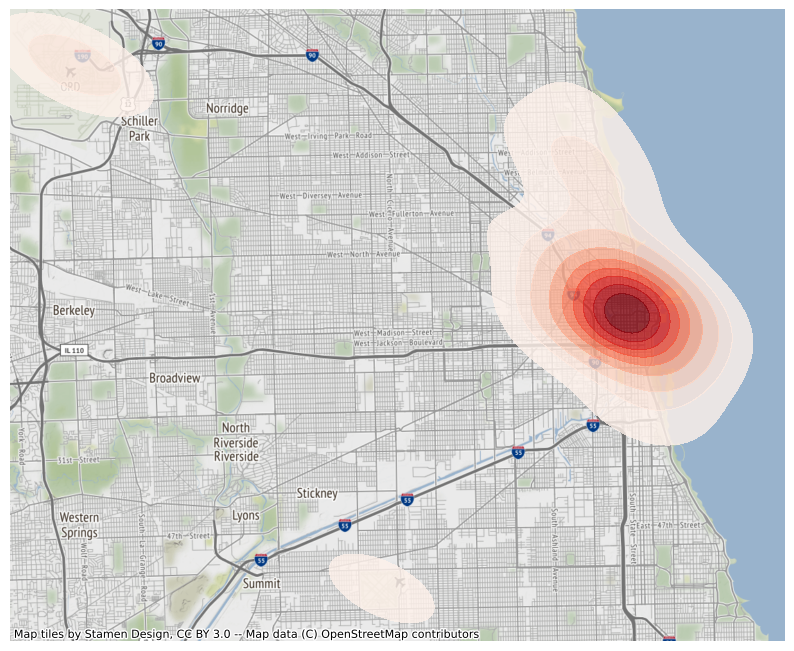

In [86]:
# Beides: einmal mit und ohne clip
levels = [0.2,0.4,0.6,0.8,1]

ax = gplt.kdeplot(
    taxi_geo_df_locations_sample['pickup_centroid_location'], 
    figsize=(10,10),
    #levels = levels,
    fill = True,
    cmap = 'Reds',
    alpha = 0.8,
    projection=gplt.crs.WebMercator(),
    #clip=boroughs.geometry
)

cx.add_basemap(ax)

<GeoAxes: >

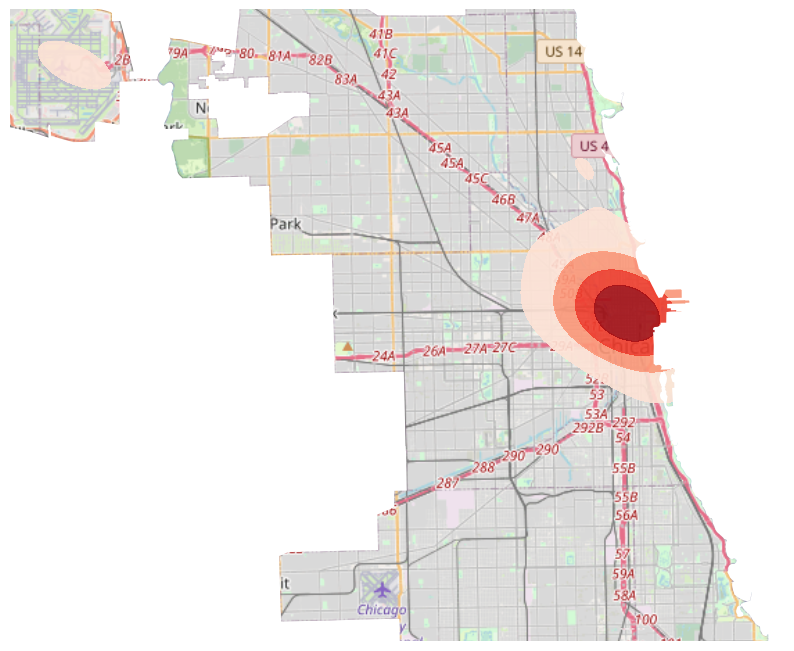

In [87]:
ax = gplt.webmap(boroughs, projection=gplt.crs.WebMercator(), figsize = (10,10))

gplt.kdeplot(
    taxi_geo_df_locations_sample['pickup_centroid_location'], 
    ax = ax,
    levels = levels,
    fill = True,
    cmap = 'Reds',
    alpha = 0.9,
    projection=gplt.crs.WebMercator(),
    clip=boroughs
)